<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list, enssim = load_data('Data')
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from postprocessing.plotting import *
viridis = plt.get_cmap('viridis')

### Generate figure

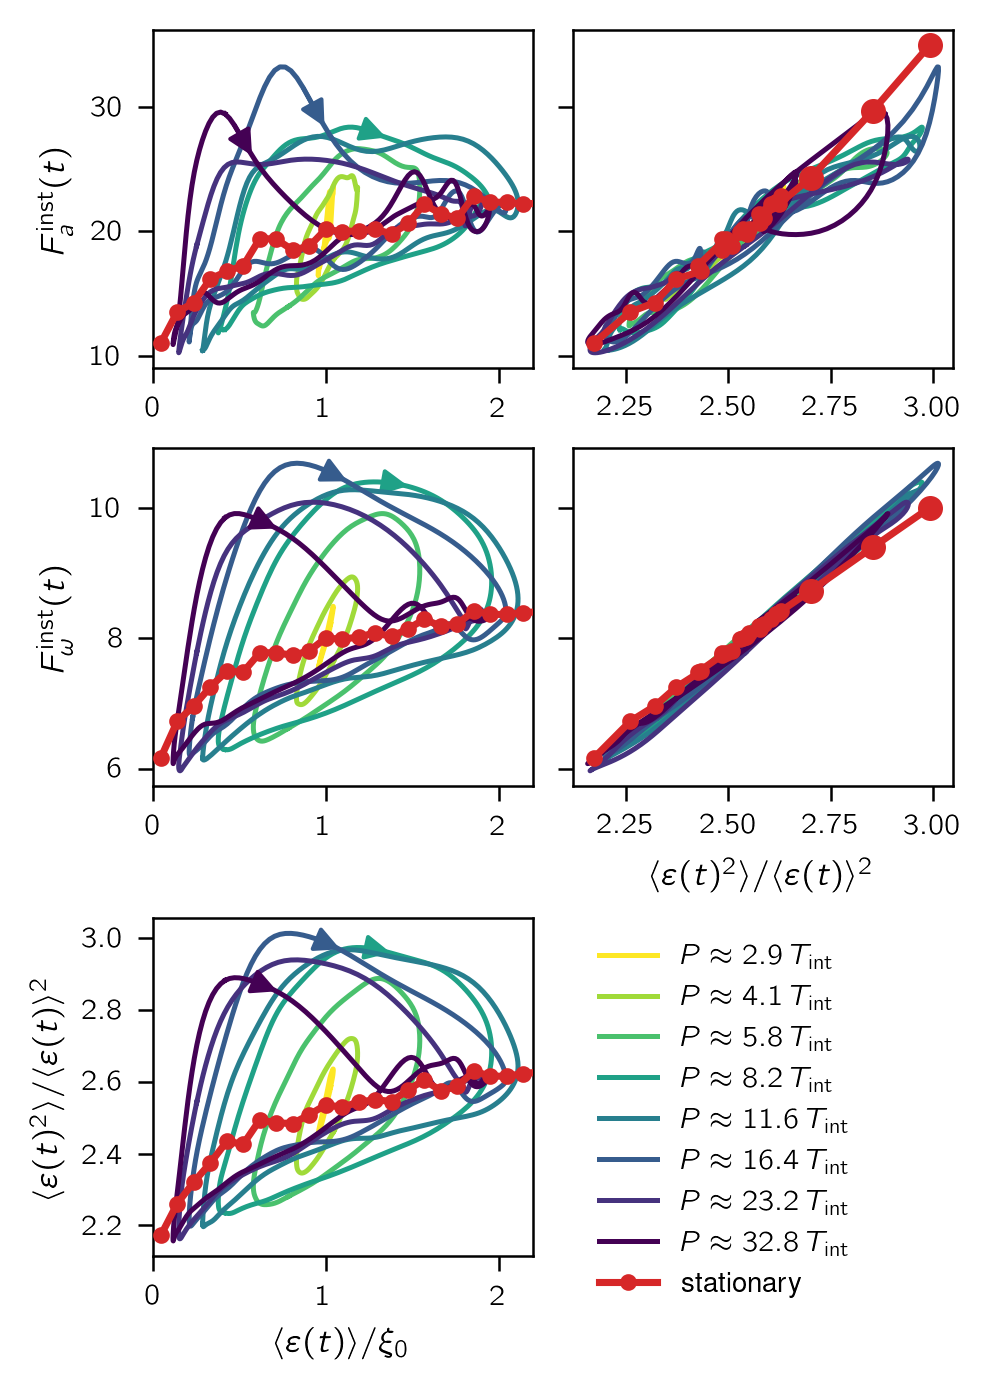

In [5]:
# select subset of simulations and filter size
varsim_list_short = varsim_list[5:]
filter_fraction = 64 # filter width is P/filter_fraction

# set up figure
fig1, axs = plt.subplots(nrows=3, ncols=2,
                         figsize=(0.6*textwidth, 0.85*textwidth),
                         sharey='row')

# iterate over oscillating simulations
for vkey, V in enumerate(varsim_list_short):
    color = viridis(1 - vkey/(len(varsim_list_short) - 1))
    t_vals = np.linspace(0, V.get_period(), 256)[:-1]
    fwidth = V.get_period()/filter_fraction

    # compute TrS2/dissipation moments
    vTrS2_mom2 = V.periodic_filter(V.statistics['moments/TrS2'][:,2], t_vals, fwidth, transient)
    vTrS2_mean = V.periodic_filter(V.statistics['moments/TrS2'][:,1], t_vals, fwidth, transient)
    vdiss = V.periodic_filter(V.statistics['diss(t)'], t_vals, fwidth, transient)
    vdissmom2norm = vTrS2_mom2/vTrS2_mean**2 # normalized 2nd moment of dissipation

    # compute acceleration and vorticity moments
    vacc_variance = V.periodic_filter(V.statistics['moments/acc'][:,2], t_vals, fwidth, transient)
    vacc_fourth = V.periodic_filter(V.statistics['moments/acc'][:,4], t_vals, fwidth, transient)
    vaccflat = vacc_fourth/vacc_variance**2
    vvort_variance = V.periodic_filter(V.statistics['moments/vort'][:,2], t_vals, fwidth, transient)
    vvort_fourth = V.periodic_filter(V.statistics['moments/vort'][:,4], t_vals, fwidth, transient)
    vvortflat = vvort_fourth/vvort_variance**2

    # mean disspation vs. acceleration flatness plot
    plt.sca(axs[0][0])
    line, = plt.plot(close_loop(vdiss)/ref.injrate,
                     close_loop(vaccflat), c = color, zorder=vkey,
                     label = r'$P \approx {}\,T_\mathrm{{int}}$'.format(
                         np.round(V.get_period()/ref.Tint, 1)))
    if len(varsim_list_short)-vkey in [1,3,5]:
        add_arrow(line, position=np.argmax(vaccflat)+4, amount=1, zorder=vkey)

    # mean disspation vs. vorticity flatness plot
    plt.sca(axs[1][0])
    line, = plt.plot(close_loop(vdiss)/ref.injrate,
                     close_loop(vvortflat),
                     c = color, zorder=vkey)
    if len(varsim_list_short)-vkey in [1,3,5]:
        add_arrow(line, position=np.argmax(vvortflat)+4, amount=1, zorder=vkey)

    # mean disspation vs. 2nd dissipation moment plot
    plt.sca(axs[2][0])
    line, = plt.plot(close_loop(vdiss)/ref.injrate,
                     close_loop(vdissmom2norm),
                     c = color, zorder=vkey)
    if len(varsim_list_short)-vkey in [1,3,5]:
        add_arrow(line, position=np.argmax(vdissmom2norm)+4, amount=1, zorder=vkey)

    # 2nd dissipation moment vs. acceleration flatness plot
    plt.sca(axs[0][1])
    plt.plot(close_loop(vdissmom2norm),
             close_loop(vaccflat),
             c = color, zorder=vkey)

    # 2nd dissipation moment vs. vorticity flatness plot
    plt.sca(axs[1][1])
    plt.plot(close_loop(vdissmom2norm),
             close_loop(vvortflat),
             c = color, zorder=vkey)

## plot statistically stationary ensemble
lw = 1.7 # line width
small_markers = 3.
large_markers = 5.
nmembers512 = len(enssim.ensemble_list[0].members) # number of smaller dots

# compute ensemble moments
ediss = enssim.get_time_averaged_ensemble_stat('diss(t)', transient)
eTrS2moments = enssim.get_time_averaged_ensemble_stat('moments/TrS2', transient)
edissspread = eTrS2moments[:,2]/eTrS2moments[:,1]**2
eaccmoments = enssim.get_time_averaged_ensemble_stat('moments/acc', transient)
eaccflat = eaccmoments[:,4]/eaccmoments[:,2]**2
evortmoments = enssim.get_time_averaged_ensemble_stat('moments/vort', transient)
evortflat = evortmoments[:,4]/evortmoments[:,2]**2

# dissipation vs. acceleration flatness plot
plt.sca(axs[0][0])
plt.plot(ediss/ref.injrate, eaccflat,
         marker='o', markersize=small_markers,
         lw=lw, color='tab:red', label='stationary', zorder=100)
plt.ylabel(r'$F_a^\mathrm{inst}(t)$')
plt.xlim(0, 2.2)

# dissipation vs. vorticity flatness plot
plt.sca(axs[1][0])
plt.plot(ediss/ref.injrate, evortflat,
         marker='o', markersize=small_markers,
         lw=lw, color='tab:red', label='stationary', zorder=100)
plt.ylabel(r'$F_\omega^\mathrm{inst}(t)$')
plt.xlim(0, 2.2)

# dissipation vs. 2nd dissipation moment plot
plt.sca(axs[2][0])
plt.plot(ediss/ref.injrate, edissspread,
         marker='o', markersize=small_markers,
         lw=lw, color='tab:red', label='stationary', zorder=100)
plt.ylabel(r'$\langle \varepsilon(t)^2 \rangle / \langle \varepsilon(t) \rangle^2$')
plt.xlabel(r'$\langle \varepsilon(t) \rangle/ \xi_0$')
plt.xlim(0, 2.2)

# 2nd dissipation moment vs. acceleration flatness plot
plt.sca(axs[0][1])
plt.plot(edissspread, eaccflat,
         lw=lw, color='tab:red',
         label='stationary', zorder=100)
plt.scatter(edissspread[:nmembers512],
            eaccflat[:nmembers512],
            marker='o', s=small_markers**2,
            color='tab:red', zorder=100)
plt.scatter(edissspread[nmembers512:],
            eaccflat[nmembers512:],
            marker='o', s=large_markers**2,
            color='tab:red', zorder=100)
plt.xlim(2.12, 3.05)

# 2nd dissipation moment vs. vorticity flatness plot
plt.sca(axs[1][1])
plt.plot(edissspread, evortflat,
         lw=lw, color='tab:red',
         label='stationary flows', zorder=100)
plt.scatter(edissspread[:nmembers512],
            evortflat[:nmembers512],
            marker='o', s=small_markers**2,
            color='tab:red', zorder=100)
plt.scatter(edissspread[nmembers512:],
            evortflat[nmembers512:],
            marker='o', s=large_markers**2,
            color='tab:red', zorder=100)
plt.xlim(2.12, 3.05)
plt.xlabel(r'$\langle \varepsilon(t)^2 \rangle / \langle \varepsilon(t) \rangle^2$')

# add legend to empty axes
plt.sca(axs[2][1])
handles, labels = axs[0][0].get_legend_handles_labels()
axs[2][1].legend(handles, labels, loc='lower left', bbox_to_anchor=(0, -0.2), frameon=False)
plt.axis('off');